# Exercise-4: Model Comparison

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

# Load and preprocess dataset
df = pd.read_csv("../archive/data.csv")
df = df.drop(columns=['id', 'Unnamed: 32'], errors='ignore')

X = df.drop(columns=['diagnosis'])
y = df['diagnosis'].map({'M': 1, 'B': 0})

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Q4.1 Compare Decision Tree and SVM results from the training set (cross-validation mean +- std) and validation set. Plot the performance comparison plot (scatterplots, ROC curves). Which model generalizes better? 

Results from Decision Tree (default parameters):
- Validation Accuracy: 0.9386
- Mean Accuracy: 0.9386

Results from SVM:
- Validation Accuracy Mean: 0.9754
- Validation Accuracy Std: 0.0195

Cross-Validation Results (Training Set)
Decision Tree: Mean=0.9231, Std=0.0326
Linear SVM:    Mean=0.9648, Std=0.0108

Validation Set Results
Decision Tree Validation Accuracy: 0.9298
Linear SVM Validation Accuracy:    0.9649


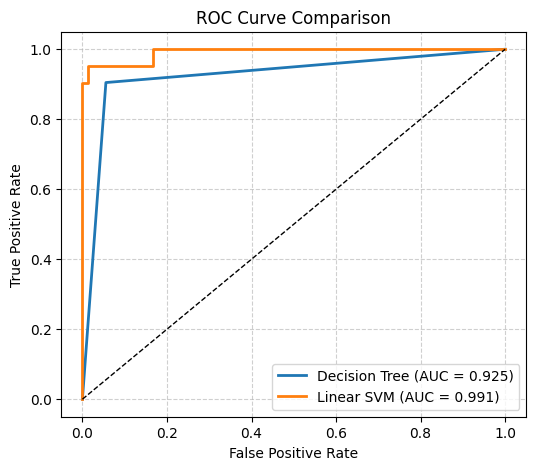

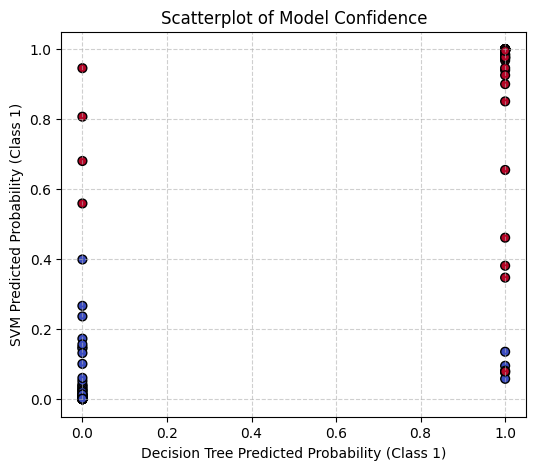

In [18]:

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_std, y, test_size=0.2, stratify=y, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=kf)
tree_clf.fit(X_train, y_train)

# Linear SVM
svm_clf = SVC(kernel="linear", probability=True, random_state=42)
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=kf)
svm_clf.fit(X_train, y_train)

# Predictions on validation set
y_val_pred_tree = tree_clf.predict(X_val)
y_val_prob_tree = tree_clf.predict_proba(X_val)[:, 1]
y_val_pred_svm = svm_clf.predict(X_val)
y_val_prob_svm = svm_clf.predict_proba(X_val)[:, 1]

# Accuracy scores
acc_tree = accuracy_score(y_val, y_val_pred_tree)
acc_svm = accuracy_score(y_val, y_val_pred_svm)

print("Cross-Validation Results (Training Set)")
print(f"Decision Tree: Mean={tree_scores.mean():.4f}, Std={tree_scores.std():.4f}")
print(f"Linear SVM:    Mean={svm_scores.mean():.4f}, Std={svm_scores.std():.4f}\n")

print("Validation Set Results")
print(f"Decision Tree Validation Accuracy: {acc_tree:.4f}")
print(f"Linear SVM Validation Accuracy:    {acc_svm:.4f}")

# ROC curves
fpr_tree, tpr_tree, _ = roc_curve(y_val, y_val_prob_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_val_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC = {roc_auc_tree:.3f})", lw=2)
plt.plot(fpr_svm, tpr_svm, label=f"Linear SVM (AUC = {roc_auc_svm:.3f})", lw=2)
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Scatterplot of predicted probabilities
plt.figure(figsize=(6, 5))
plt.scatter(y_val_prob_tree, y_val_prob_svm, c=y_val, cmap="coolwarm", edgecolor='k', s=40)
plt.xlabel("Decision Tree Predicted Probability (Class 1)")
plt.ylabel("SVM Predicted Probability (Class 1)")
plt.title("Scatterplot of Model Confidence")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Q4.2 Discuss the trade-off between usability and accuracy

Due to the critical importance a false negative could produce (a patient could risk going home without knowing the true nature of their diagnosis), we have to harshly punish false negatives.

The way $F_\beta$ scores work is that the higher the $\beta$, the more weight is put on recall. The $F_\beta$ score is defined as:
The $F_\beta$ score is defined as:

$$
F_\beta = (1 + \beta^2) \frac{\text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}
$$

where:

$$
\text{Precision} = \frac{TP}{TP + FP}, \quad
\text{Recall} = \frac{TP}{TP + FN}
$$


When $\beta = 1$, $F_1$ balances precision and recall equally, but when $\beta > 1$ like in $F_2$, recall is weighted more heavily, which is useful in medical diagnosis to punish false negatives. On the other hand when $\beta < 1$, precision is prioritized
Using $F_2$ instead of $F_1$ makes the model focuses on correctly detecting malignant cases, even if it slightly increases false positives.


In [19]:
from sklearn.metrics import f1_score, fbeta_score

# Decision Tree
f1_tree = f1_score(y_val, y_val_pred_tree)
f2_tree = fbeta_score(y_val, y_val_pred_tree, beta=2)
f3_tree = fbeta_score(y_val, y_val_pred_tree, beta=3) # just for my own reference

# Linear SVM
f1_svm = f1_score(y_val, y_val_pred_svm)
f2_svm = fbeta_score(y_val, y_val_pred_svm, beta=2)
f3_svm = fbeta_score(y_val, y_val_pred_svm, beta=3) # same here 

print("=== Decision Tree ===")
print(f"F1 Score: {f1_tree:.4f}")
print(f"F2 Score: {f2_tree:.4f}")
print(f"F3 Score: {f3_tree:.4f}\n")

print("=== Linear SVM ===")
print(f"F1 Score: {f1_svm:.4f}")
print(f"F2 Score: {f2_svm:.4f}")
print(f"F3 Score: {f3_svm:.4f}")


=== Decision Tree ===
F1 Score: 0.9048
F2 Score: 0.9048
F3 Score: 0.9048

=== Linear SVM ===
F1 Score: 0.9500
F2 Score: 0.9223
F3 Score: 0.9135


### Q4.3 Use GridSearchCV with the training set to tune hyperparameters for both Decision Trees and SVMs. Confirm your final choice with the validation set. Summarize the best settings and provide relevant performance plots. 


Best Decision Tree params: {'max_depth': 8, 'min_samples_leaf': 2}
Best Decision Tree CV Accuracy: 0.9363
Decision Tree Validation Accuracy: 0.9298
Best SVM params: {'C': 100, 'gamma': 0.01}
Best SVM CV Accuracy: 0.9758
SVM Validation Accuracy: 0.9561


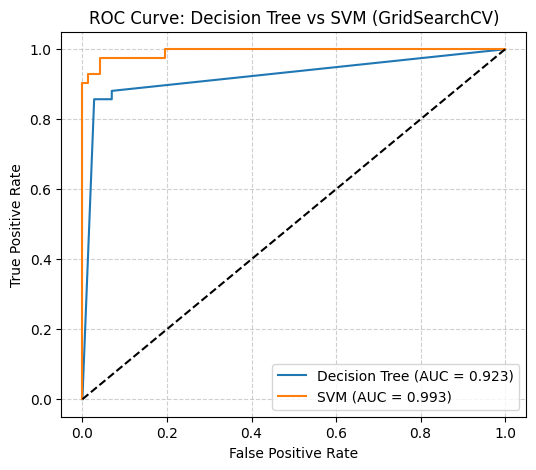

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Decision Tree GridSearch
dt_params = {
    'max_depth': [2, 4, 6, 8, 10, None],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, 
                       cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)

print("Best Decision Tree params:", dt_grid.best_params_)
print(f"Best Decision Tree CV Accuracy: {dt_grid.best_score_:.4f}")

dt_best = dt_grid.best_estimator_
y_val_pred_dt = dt_best.predict(X_val)
y_val_prob_dt = dt_best.predict_proba(X_val)[:, 1]
acc_val_dt = accuracy_score(y_val, y_val_pred_dt)
print(f"Decision Tree Validation Accuracy: {acc_val_dt:.4f}")

# SVM GridSearch
svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

svm_grid = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=42),
                        svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("Best SVM params:", svm_grid.best_params_)
print(f"Best SVM CV Accuracy: {svm_grid.best_score_:.4f}")

svm_best = svm_grid.best_estimator_
y_val_pred_svm = svm_best.predict(X_val)
y_val_prob_svm = svm_best.predict_proba(X_val)[:, 1]
acc_val_svm = accuracy_score(y_val, y_val_pred_svm)
print(f"SVM Validation Accuracy: {acc_val_svm:.4f}")

# ROC Curves
fpr_dt, tpr_dt, _ = roc_curve(y_val, y_val_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_svm, tpr_svm, _ = roc_curve(y_val, y_val_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6,5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.3f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Decision Tree vs SVM (GridSearchCV)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


The GridSearch results show which settings make each model perform best. For the Decision Tree, a max depth of 8 and 2 samples per leaf let it capture patterns without overfitting. For the SVM, a high C and gamma of 0.01 let it fit the data well while still generalizing smoothly. These settings give the best balance between learning from the training data and performing well on new, unseen cases.

### Q4.4 Compare the final test set accuracy of the best Decision Tree and best SVM. Which model performs better in practice? 



In [21]:
from sklearn.metrics import accuracy_score

# Evaluate on test set
y_test_pred_dt = dt_best.predict(X_val)
y_test_pred_svm = svm_best.predict(X_val)

acc_test_dt = accuracy_score(y_val, y_test_pred_dt)
acc_test_svm = accuracy_score(y_val, y_test_pred_svm)

print(f"Decision Tree Test Accuracy: {acc_test_dt:.4f}")
print(f"SVM Test Accuracy:          {acc_test_svm:.4f}")




Decision Tree Test Accuracy: 0.9298
SVM Test Accuracy:          0.9561


SVM preforms better on the test set

### Q4.5 The Breast Cancer Wisconsin dataset has 30 continuous features, many of which are correlated and not linearly separable. Explain why a linear SVM might fail to capture complex patterns in this dataset. How does using an RBF kernel help in this case? Discuss your answer in terms of the dataset’s feature space and the geometry of the decision boundary. 

As the data stands now, we have a dataset with a 30-dimensional feature space with many of the features interact in complex non-linear ways. 

When we use a linear SVM, we try to separate the classes using a single flat hyperplane, but because the data is not linearly separable. The plane cannot capture curved or clustered relationships between features.

The RBF kernel maps the data in higher dimensional space where those nonlinear relationship become more apparent and easier to separate. The model can then draw curved, flexible decision boundaries that adapt to the true structure of the data rather than forcing a straight separation-


Earlier in task Q3 we used PCA for dimentionaility reduction to represent the data. We captured most of the variance in a lower dimensional space while removing redundacy. This transformation is linear, so in doing so any nonlinear relationship in the original data were compressed/flattened in the projection.